In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from astropy.io import fits
from IPython.core.display import display, HTML
display(HTML('<style>.container{width:97% !important;}</style>'))
%matplotlib notebook

## EIS project for The Sun's atmosphere - 21.03.19

In [2]:
directory = "FE_XVI"
files = sorted(os.listdir(directory))

In [6]:
test_fits = fits.open(os.path.join(directory,files[0]))

SIMPLE  =                    T / Written by IDL:  Tue Aug  2 20:50:48 2016      
BITPIX  =                  -32 / IEEE single precision floating point           
NAXIS   =                    2 /                                                
NAXIS1  =                   30 /Number of positions along axis 1                
NAXIS2  =                  152 /Number of positions along axis 2                
XCEN    =             -858.665 /                                                
YCEN    =        191.859178015 /                                                
LINE_ID = 'FE XVI 262.980'     /                                                
LAMBDA  =        262.712951443 /                                                
X_STEP  =              5.78160 /                                                
Y_STEP  =       0.993421052632 /                                                

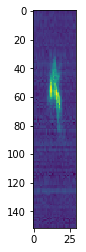

In [17]:
plt.imshow(test_fits[0].data)
test_fits[0].header

SIMPLE  =                    T / Written by IDL:  Tue Aug  2 20:50:48 2016      
BITPIX  =                  -32 / IEEE single precision floating point           
NAXIS   =                    2 /                                                
NAXIS1  =                   30 /Number of positions along axis 1                
NAXIS2  =                  152 /Number of positions along axis 2                
XCEN    =             -858.665 /                                                
YCEN    =        191.859178015 /                                                
LINE_ID = 'FE XVI 262.980'     /                                                
LAMBDA  =        262.735208904 /                                                
X_STEP  =              5.78160 /                                                
Y_STEP  =       0.993421052632 /                                                

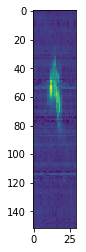

In [18]:
second_test_fits = fits.open(os.path.join(directory,files[2]))
plt.imshow(second_test_fits[0].data)
second_test_fits[0].header

So each FITS file is an image at one specific wavelength
### Set up function to read in data
Function takes the directory, loads in files to a single data cube, makes a header and array of wavelength values

In [57]:
def combinefits(directory,write=False):
    """
    inputs
    ------
    directory: str, path to the FITS files
    write: bool, save FITS files y/n
   
    
    returns
    -------
    fits-out: FITS hdulist containing data cube, header and wavelength information
    err-out: FITS hdulist containing data cube of errors, header and wavelength info
    """
    import numpy as np
    import os
    from astropy.io import fits
    
    # --- identify list of files --- #
    files = sorted(os.listdir(directory))
    
    # --- create empty objects to fill with data, errors and wavelengths --- #
    datacube = []
    errcube  = []
    wavelengths = []
    
    
    # --- set loop over all files in directory and extract relevant data to each of the created object --- #
    
    for file in files:
        
        fits_loaded = fits.open(os.path.join(directory,file))
        
        if "_err" not in file:
            datacube.append(fits_loaded[0].data) 
        else:
            errcube.append(fits_loaded[0].data)
        
            wavelengths.append(fits_loaded[0].header['LAMBDA'])   # we only want the wavelengths extracted once per data/err pair
    
    # --- convert to numpy arrays --- #
    
    datacube = np.array(datacube)
    errcube = np.array(errcube)
    wavelengths = np.array(wavelengths)
    
    # --- create new FITS headers. data and err will have identical headers --- #
    
    primary_header = fits.Header(fits_loaded[0].header)
    primary_header['LAMBDA'] = "----"
    
    secondary_header = fits.Header()
    secondary_header['N'] = len(wavelengths)
    secondary_header['COMMENT'] = "Wavelength values in Angstroms"
    
    # --- create FITS data levels --- #

    primary_hdu_data = fits.PrimaryHDU(datacube,header=primary_header)
    
    primary_hdu_err = fits.PrimaryHDU(errcube,header=primary_header)
    
    secondary_hdu = fits.ImageHDU(wavelengths,header=secondary_header)
    
    # --- assemble the FITS file structures --- #
    
    hdulist_data = fits.HDUList([primary_hdu_data,secondary_hdu])
    
    hdulist_err  = fits.HDUList([primary_hdu_err,secondary_hdu])

    if write==True:
        hdulist_data.writeto(directory+"_data.fits")
        hdulist_err.writeto(directory+"_err.fits")
    
    return datacube,errcube,wavelengths

In [51]:
# test fits writing

#primary header
primary_header = fits.Header(test_fits[0].header)
primary_hdu = fits.PrimaryHDU(d,header=primary_header)
secondary_header = fits.Header()
secondary_hdu = fits.ImageHDU(w)
hdulist = fits.HDUList([primary_hdu,secondary_hdu])

In [52]:
hdulist[1].data

array([262.71295144, 262.7352089 , 262.75746634, 262.77972375,
       262.80198113, 262.82423848, 262.84649581, 262.86875311,
       262.89101039, 262.91326764, 262.93552486, 262.95778205,
       262.98003922, 263.00229636, 263.02455348, 263.04681057,
       263.06906763, 263.09132467, 263.11358167, 263.13583866,
       263.15809561, 263.18035254, 263.20260945, 263.22486632])

Now that the function is written, run for the three spectral lines

In [58]:
for directory in ["O_V","FE_XVII","FE_XVI"]:
    combinefits(directory,write=True);

Plotting an intensity map

In [191]:
fits.open("Combined-FITS/O_V_data.fits")[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                   30                                                  
NAXIS2  =                  152                                                  
NAXIS3  =                   16                                                  
EXTEND  =                    T                                                  
XCEN    =             -858.665 /                                                
YCEN    =        190.745958079 /                                                
LINE_ID = 'O V 248.480'        /                                                
LAMBDA  = '----    '                                                            
X_STEP  =              5.78160 /                                                
Y_STEP  =       0.9934210526

To scale the xs and ys appropriately, use XCEN, YCEN and X_STEP, Y_STEP. e.g.
$$X_{lims} (arcsec) = XCEN \pm (NAXIS/2)\times X\_STEP$$

Make a function to plot the intensity maps of the 3 lines.

In [217]:
def plotintensity(file,**kwargs):
    hdul = fits.open(file)
    h = hdul[0].header
    
    I_map = np.sum(hdul[0].data,axis=0)
    
    x_left   = h['XCEN'] - (h['NAXIS1']*0.5*h['X_STEP'])
    x_right  = h['XCEN'] + (h['NAXIS1']*0.5*h['X_STEP'])
    
    y_top    = h['YCEN'] - (h['NAXIS2']*0.5*h['Y_STEP'])
    y_bottom = h['YCEN'] + (h['NAXIS2']*0.5*h['Y_STEP'])
    
    
    f,ax = plt.subplots(1,1)
    im = ax.imshow(I_map,origin='lower',extent=(x_left, x_right, y_top, y_bottom),**kwargs)
    ax.set_title('Intensity map '+file[14:-10])
    ax.set_ylabel('Solar Y [arcsec]')
    ax.set_xlabel('Solar X [arcsec]')
    
    #ax.set_xticklabels(xs)
    #ax.set_yticklabels(ys)
    plt.colorbar(im)
    
    return xs,ys

<IPython.core.display.Javascript object>


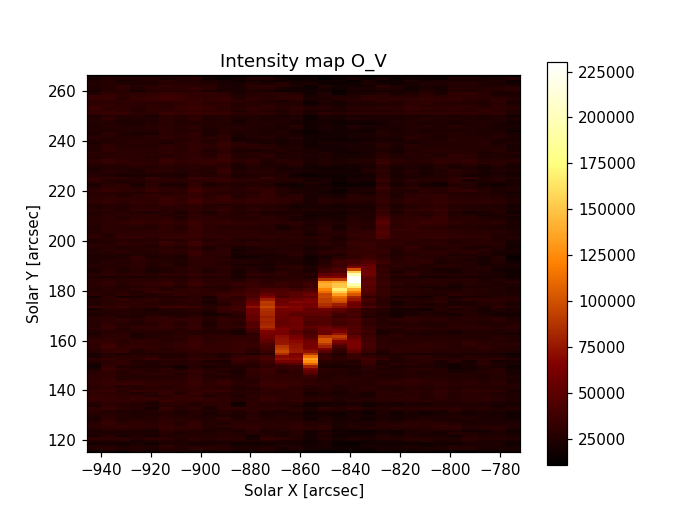

<IPython.core.display.Javascript object>


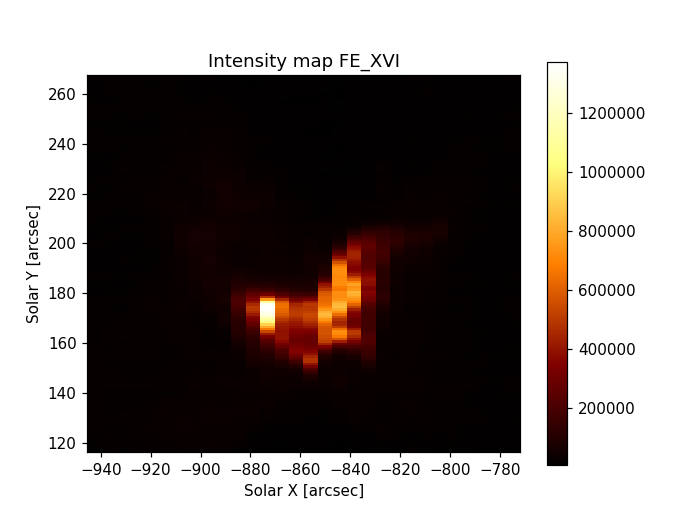

<IPython.core.display.Javascript object>


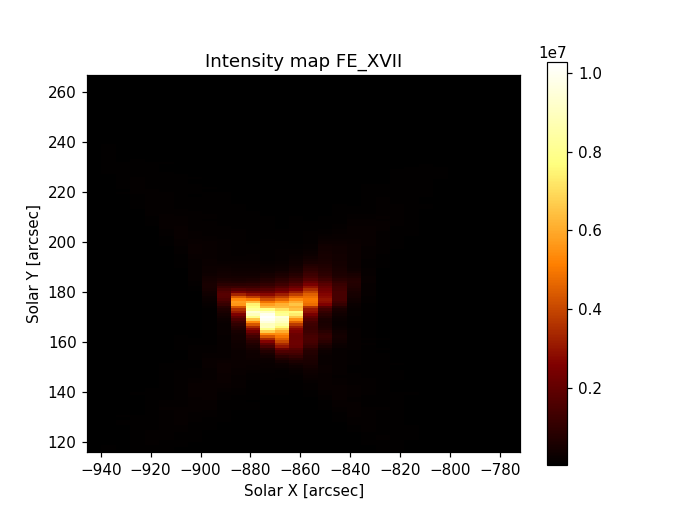

In [218]:
%matplotlib notebook
for line in ["O_V","FE_XVI","FE_XVII"]:
    xs,ys=plotintensity("Combined-FITS/%s_data.fits" %line,cmap='afmhot')

### Section 2.2 - Diagnosing the Plasma Temperatures
###### Question 2.1 - Which parts of the flare and background are hotter?
Plot all three intensity maps on the same plot via contours...

<IPython.core.display.Javascript object>


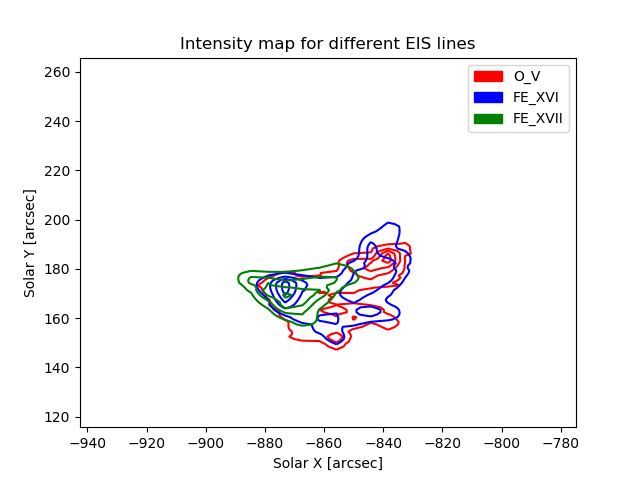

In [20]:
# get a header and get header info for plot extents
import matplotlib.patches as mpatches
%matplotlib notebook
h = fits.open("Combined-FITS/O_V_data.fits")[0].header

x_left   = h['XCEN'] - (h['NAXIS1']*0.5*h['X_STEP'])
x_right  = h['XCEN'] + (h['NAXIS1']*0.5*h['X_STEP'])

y_top    = h['YCEN'] - (h['NAXIS2']*0.5*h['Y_STEP'])
y_bottom = h['YCEN'] + (h['NAXIS2']*0.5*h['Y_STEP'])

plt.figure()
handles=[]
for line,cmp in zip(["O_V","FE_XVI","FE_XVII"],["red","blue","green"]):
    data = fits.getdata("Combined-FITS/%s_data.fits" %line)
    plot_this = np.sum(data,axis=0)
    
    # plot each one
    contour = plt.contour(plot_this,origin='lower',extent=(x_left, x_right, y_top, y_bottom),levels=4,colors=cmp)
    handles.append(mpatches.Patch(color=cmp, label=line))

plt.title('Intensity map for different EIS lines');
plt.xlabel('Solar X [arcsec]');
plt.ylabel('Solar Y [arcsec]');

# plot legend #

plt.legend(handles=handles);


#plt.legend([handles[0][0],handles[1][0],handles[2][0]], ['O_V', 'FE_XVI','FE_XVII'])

### Section 2.3 - Isolating Spectral Lines
Begin by making helper functions for pix to arcsec

In [269]:
fits.open("Combined-FITS/O_V_data.fits")[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                   30                                                  
NAXIS2  =                  152                                                  
NAXIS3  =                   16                                                  
EXTEND  =                    T                                                  
XCEN    =             -858.665 /                                                
YCEN    =        190.745958079 /                                                
LINE_ID = 'O V 248.480'        /                                                
LAMBDA  = '----    '                                                            
X_STEP  =              5.78160 /                                                
Y_STEP  =       0.9934210526

In [52]:
def pixtoarcsec(x_pix,y_pix):
    XCEN   = -858.665
    YCEN   =  190.745958079
    X_STEP =  5.78160
    Y_STEP =  0.993421052632
    NX     =  30.
    NY     =  152.
    
    x_arcsec = XCEN - (NX*0.5 - x_pix)*X_STEP
    y_arcsec = YCEN - (NY*0.5 - y_pix)*Y_STEP

    return x_arcsec, y_arcsec

In [275]:
pixtoarcsec(0,0)

(-945.389, 115.24595807896799)

Inverse operation for arcsec to pixel:
$$XCEN - x_{arcsec} = (NX/2 - xpix)*X\_STEP$$
$$(XCEN - x_{arcsec})/X\_STEP = (NX/2 - xpix)$$
$$NX/2 - (XCEN - x_{arcsec})/X\_STEP = xpix$$

In [4]:
def arcsectopix(x_arcsec,y_arcsec):
    XCEN   = -858.665
    YCEN   =  190.745958079
    X_STEP =  5.78160
    Y_STEP =  0.993421052632
    NX     =  30.
    NY     =  152.
    
    x_pix = NX*0.5 - (XCEN - x_arcsec)/X_STEP
    y_pix = NY*0.5 - (YCEN - y_arcsec)/Y_STEP
    
    return round(x_pix), round(y_pix)

In [280]:
arcsectopix(-780,260)

(29, 146)

#### Question 2.2 - Plot sample line profiles
Start by making a function to do this

In [53]:
def plotspectrum(file,x,y,mode="arcsec",plot=False):
    """
    inputs: 
    x,y: arcsec or pixels
    file: string, path to fits file
    mode: str, pix or arcsec
    
    plots the spectral line at that point
    """
    
    # change coords if necessary
    if mode=="arcsec":
        x_, y_ = arcsectopix(x,y)
    elif mode=="pix":
        x_, y_ = x, y
    
    
    x_ , y_ = int(x_), int(y_)
    
    # load fits file
    hdu = fits.open(file)
    
    plot_this = hdu[0].data[:,y_,x_]
    wavelengths = hdu[1].data
    
    return plot_this, wavelengths

    if plot==True:
        plt.figure()
        plt.plot(wavelengths, plot_this)
        plt.title("Spectral plot of %s at %d,%d"%(file[14:-10],x,y))
        plt.xlabel('Wavelength [$\AA$]')
        plt.ylabel('Intensity')

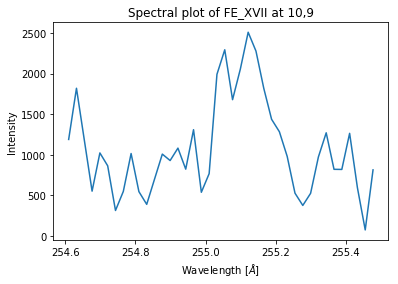

In [18]:
plotspectrum("Combined-FITS/FE_XVII_data.fits", 10,9,mode='pix')

#### 28.03.19


### Question 2.2 - Plot lines
Shape of the line can tell you about the mechanisms producing contrast in your image. A line with a peak is an emission - hot plasma emitting photons from electron level transitions. An absorption line comes from cool plasma illuminated from behind - continuum photons are absorbed by the plasma.

Pick three locations,
1. x,y = -873", 172"
2. x,y = -838", 183"
3. x,y = -856", 151"

Plot all three spectral lines at the three locations:

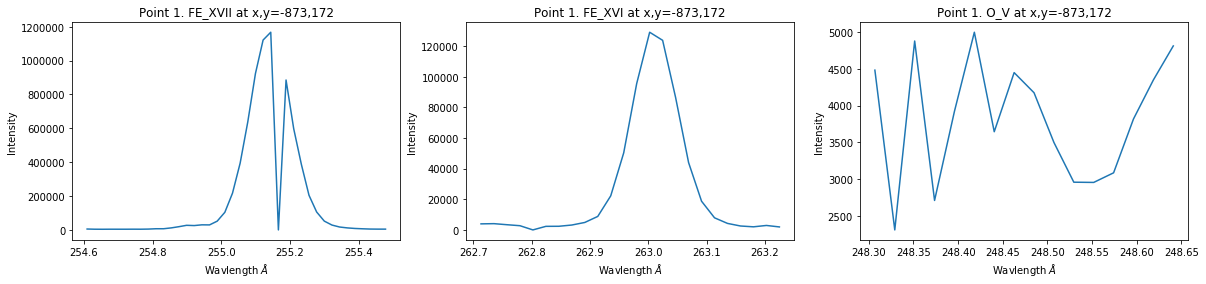

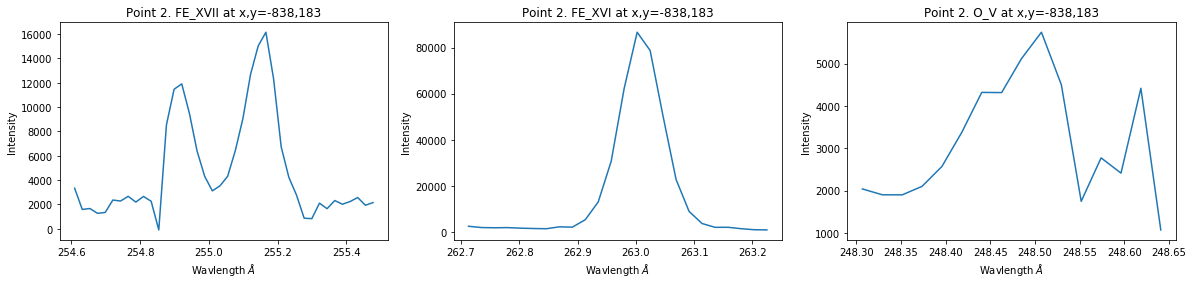

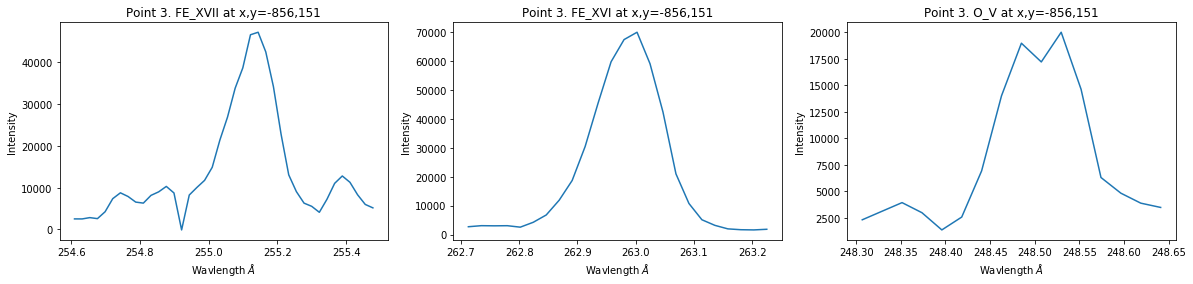

In [57]:
# define the points
%matplotlib inline
points = [[-873,172],[-838,183],[-856,151]]
lines = sorted(os.listdir("Combined-FITS"))
# make 3,1 subplots with all the lines at each point
j=1
for p in points:
    f,ax = plt.subplots(1,3,figsize=(20,4))
    i = 0
    for line in lines:
        if "err" not in line:
            plotline,wls = plotspectrum(os.path.join("Combined-FITS",line),p[0],p[1],mode="arcsec")
            
            ax[i].plot(wls, plotline)
            ax[i].set_title("Point %d. %s at x,y=%d,%d"%(j,line[:-10],p[0],p[1]))
            ax[i].set_xlabel(r'Wavlength $\AA$')
            ax[i].set_ylabel('Intensity')
            i+=1
    j+=1

### Question 2.3 - reasons for rejecting other lines
The other lines are rejected because they do not exhibit simple Gaussian shapes, while FE XVI does (middle column).

### Removing negative values in FE XVI data

In [20]:
# load in the data/error files

d = fits.open("Combined-FITS/FE_XVI_data.fits")
e = fits.open("Combined-FITS/FE_XVI_err.fits")
dat = d[0].data
err  = e[0].data

In [47]:
# set up loops to cover all pixels
for x in range(dat.shape[2]):      # go through x
    for y in range(dat.shape[1]):  # go through y
        
        for wl in range(1,(dat.shape[0])-1): # go through wavelengths, cannot check edge values
            
            # first condition: if there is a negative data value
            if dat[wl,y,x]<0:       
                if dat[wl+1,y,x]<0 and dat[wl-1,y,x]<0:  # if both neighbours are negative set to 0
                    dat[wl,y,x]=0
                    err[wl,y,x]=0
                    
                    # if one neighbour is negative, use the other neighbour
                elif dat[wl+1,y,x]<0: 
                    dat[wl,y,x]=dat[wl-1,y,x]
                    err[wl,y,x]=err[wl-1,y,x]
                elif dat[wl-1,y,x]<0:
                    dat[wl,y,x]=dat[wl+1,y,x]
                    err[wl,y,x]=err[wl+1,y,x]
                    
                    # else, use the average of the two neighbours
                else:
                    dat[wl,y,x]=(dat[wl+1,y,x]+dat[wl-1,y,x])/2
                    err[wl,y,x]=(err[wl+1,y,x]+err[wl-1,y,x])/2
            
            # same exact thing but conditions changed for negative values in errors
            
            if err[wl,y,x]<0:
                if err[wl+1,y,x]<0 and err[wl-1,y,x]<0:
                    dat[wl,y,x]=0
                    err[wl,y,x]=0
                elif err[wl+1,y,x]<0:
                    dat[wl,y,x]=dat[wl-1,y,x]
                    err[wl,y,x]=err[wl-1,y,x]
                elif err[wl-1,y,x]<0:
                    dat[wl,y,x]=dat[wl+1,y,x]
                    err[wl,y,x]=err[wl+1,y,x]
                else:
                    dat[wl,y,x]=np.mean(dat[wl+1,y,x],dat[wl-1,y,x])
                    err[wl,y,x]=np.mean(err[wl+1,y,x],err[wl-1,y,x]) 

In [48]:
# check number of negatives left over
ds=np.sum(dat<0)
es=np.sum(err<0)
print("%d negative data values, %d negative error values"%(ds,es))

125 negative data values, 4 negative error values


### 29.03.19
The negative could be at the edges of the wavelength arrays, which couldn't be checked

In [49]:
dedge = np.sum(dat[0,:,:]<0)+ np.sum(dat[-1,:,:])
eedge = np.sum(err[0,:,:]<0)+ np.sum(err[-1,:,:])
print("%d negative data edge values, %d negative error edge values"%(ds,es))

125 negative data edge values, 4 negative error edge values


Can see that this is exactly what happened. When fitting I should leave out these values.
Quick check how many values are now equal to zero:

In [50]:
# check number of zeros left over
ds=np.sum(dat==0)
es=np.sum(err==0)
print("%d 0 data values, %d 0 error values"%(ds,es))

60 0 data values, 0 0 error values


### Question 2.4 - Gaussian fitting
First, define a gaussian.

In [8]:
def gaussian(X,amp,sig,x0):
    return (amp*(2*np.pi*sig**2)**(-0.5))*np.e**(-(X-x0)**2/(2*sig**2))

Get the right x and ydata then use curve_fit

popt [1.00699934e+04 5.75885850e-02 2.62986886e+02]


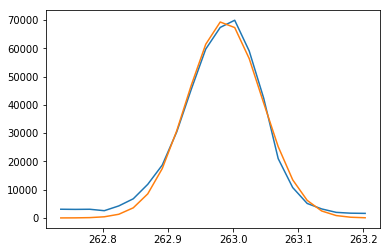

In [77]:
from scipy.optimize import curve_fit
line="FE_XVI_data.fits"

ydata, xdata = plotspectrum(os.path.join("Combined-FITS",line),p[0],p[1],mode="arcsec")

ydata=ydata[1:-1]
xdata=xdata[1:-1]
p0=(np.max(ydata),0.1,263)
popt,pcov = curve_fit(gaussian,xdata,ydata,p0=p0)
print("popt",popt)
plt.figure()
plt.plot(xdata,ydata)
plt.plot(xdata,gaussian(xdata,*popt))

Make a function for curve fitting gaussians and plotting with errors.

In [118]:
def fitgauss(x,y,mode="arcsec", plot=False):
    from scipy.optimize import curve_fit
    import matplotlib.patches as mpatches
    # change coords if necessary
    if mode=="arcsec":
        x_, y_ = arcsectopix(x,y)
    elif mode=="pix":
        x_, y_ = x, y
    
    
    x_ , y_ = int(x_), int(y_)
    
    # open fits files of Fe XVI data/errors
    
    dat = fits.open("Combined-FITS/FE_XVI_data.fits")
    err = fits.open("Combined-FITS/FE_XVI_err.fits")
    
    # extract data/errors
    linevals = dat[0].data[:,y_,x_]
    wavelengths = dat[1].data
    lineerrors = err[0].data[:,y_,x_]
    dat.close()
    err.close()
    
    
    # cut off the ends because of possible negatives
    vals = linevals[2:-2]
    errs = lineerrors[2:-2]
    wls  = wavelengths[2:-2]
    
    # curve fit initial guesses for amp, sig, x0
    p0 = (np.max(vals),0.1,np.median(wls))
    
    # curve fit w/ errors
    popt,pcov = curve_fit(gaussian,wls,vals,p0=p0,sigma=errs)
    
    # better resolution line for plotting fitted model
    xs = np.arange(wls[0],wls[-1],0.001)
    

    if plot==True:
        
        f,ax = plt.subplots()
        ax.errorbar(wls,vals,yerr=errs, label='data',color='Blue')
        ax.plot(xs,gaussian(xs,*popt),label='fit',color='Orange')
        
        datp = mpatches.Patch(color='Orange', label="data")
        fitp = mpatches.Patch(color='Blue', label="fit")
        textstr = '\n'.join((
        r'$A_0=%.0f$' % (popt[0], ),
        r'$\sigma=%.2f$' % (abs(popt[1]), ),
        r'$\lambda_0=%.1f$' % (popt[2], ),))
        
        props = dict(boxstyle='round', facecolor='white',edgecolor='#003865', alpha=1)
        
        
        
        plt.text(0.025, 0.82
                 , textstr,
                 transform=ax.transAxes, 
                 fontsize=10,
        verticalalignment='top', bbox=props)
        plt.title("Gaussian fit to Fe XVI line at x, y = %d, %d" %(x,y))
        
        plt.legend(loc="upper left",edgecolor='#003865',facecolor='white')
        plt.ylabel('Intensity')
        plt.xlabel(r'Wavelength [$\AA$]')
        plt.show()
        
    return popt, pcov

<IPython.core.display.Javascript object>


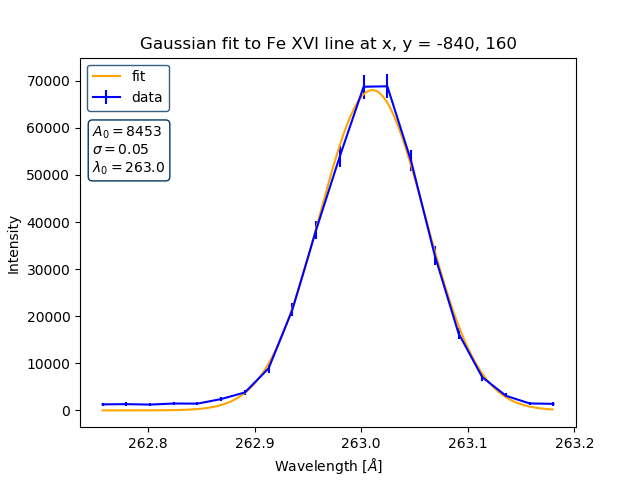

In [119]:
%matplotlib notebook
fitgauss(-840,160,mode="arcsec",plot=True);